In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.ticker as mtick

In [4]:
import decision_trees_helper
%aimport decision_trees_helper

import class_helper
%aimport class_helper

In [5]:
# Generate plots for use in the notebook
ens_h = decision_trees_helper.Ensemble_Helper()
data = ens_h.make_iris()

ens_result = ens_h.make_ens( pairs=[ [0,2] ])
fig_submodels, axs_submodels = ens_result["individual models plot"]
fig_sum, axs_sum = ens_result["ensemble plot"]
pairs = ens_result["pairs"]

RandomForest with 30 estimators with features [0, 2] has a score of 0.9466666666666667


In [6]:
# Pick one pair, one model from the list of (pairs x models) to plot
pair_idx, model_idx = 0,0
pair = pairs[pair_idx]

ens_estimators = ens_result["estimators"][pair_idx][model_idx]
X, y = ens_result["individual model data"][pair_idx][model_idx]

fig_ens = ens_h.plot_ens(X, y, ens_estimators, feature_names=[ "$x_{i:d}$".format(i=idx+1) 
                                                              for i, idx in enumerate(pair)
                                                             ])

# Ensembles

Following our Recipe for Machine Learning, we may try out several models before deciding on the final one.

Is a single "best" model really best ? Is there an alternative ?

By combining models with independent errors, we may be able to construct a combined model
whose accuracy is better than the best individual model.

The combined models are called an *Ensemble*.

The individual models
- May be of different types: 
    - Decision Tree, Logistic Regression, KNN
- May be of the *same* type. Models differ by
    - different parameters/hyper-parameters:
        - Decision Trees of different depths or different features
        - Regression with polynomial features of different degrees
    - training datasets
        - subsets of full dataset

When the individual models are of the same type
- Each individual model is trained on a *different* subset of the training examples
- This enables the individual models to produce different results
- Makes them more robust to outliers

We will shortly explain how the subsets are chosen.

Here is an Ensemble of individual models of the same type: Decision Trees
- classification among 3 classes
- trained on different subsets of the training dataset
    - details to follow: Bagging, Boosting
- we have limited the features used to $\x_1, \x_3$ only to make the diagrams smaller

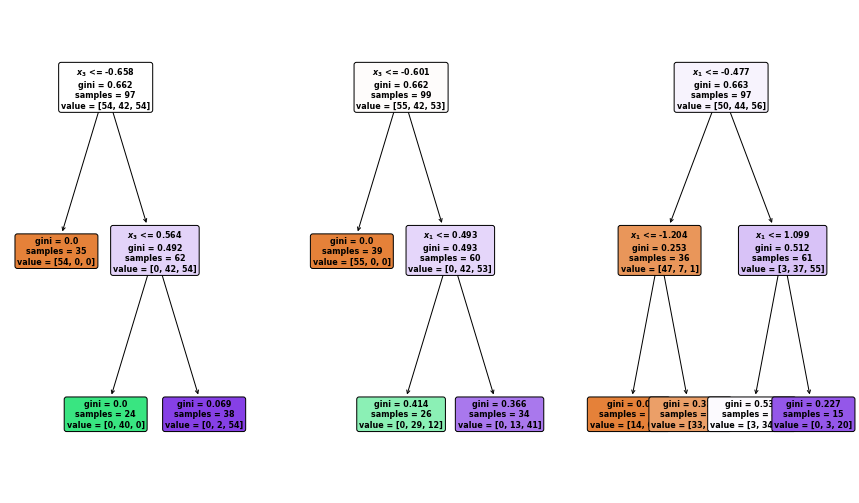

In [7]:
fig_ens

The individual models are usually quite simple and restricted.
- They are *weak learners*: accuracy only marginally better than chance
- But combine to create a *strong learner*.


If the prediction of an ensemble of $M$ binary classifiers is based on a "majority vote"
- The prediction is incorrect only if $m' \ge \ceil{M/2}$ classifiers are incorrect
- The probability of a particular set of $m'$ models of equal accuracy $A$ all being incorrect is
$
{ (1 - A)^{m'} }
$
- There are $$ \begin{pmatrix} M \\ m' \\
\end{pmatrix}
$$
combinations of $m'$ models
- So the probability of a correct ensemble prediction when $m'$ classifiers are incorrect is
$$
1- \begin{pmatrix} M \\ m' \\
\end{pmatrix} *  { (1 - A)^{m'} }
$$
which tends to $1$ as $M$ ( and hence, $m' \ge \ceil{M/2}$) increases.
    - since $(1 - A) < 1$
    - when raised to a power ($m'$) the second term goes to $0$

The power of Ensembles comes via the size of $M$.

Ensembling is independent of the types of the individual models
- A meta-model that can combine many different types of individual models
- Under the assumption of **independent** errors
- Often applied in competitions

 ## Ensemble prediction

Each individual model comes up with a prediction for the target $\hat{\y}^\ip$ of example $i$,
given features $\x^\ip$.

Let
$p_{\tp,c}^\ip$
- Denote the probability predicted by the $\tt^{th}$ individual classifier
- That target $\y^\ip$ is in category $c \in C$
- Given features $\x^\ip$

The class predicted by the ensemble is the one with highest average  (across individual models) probability
$$
\hat{\y}^\ip = \argmax{c}{ \sum_{\tt=1}^M} { p_{\tp,c}^\ip }
$$



Returning to the Ensemble of Decision Trees example, we can plot the decision boundary of
each individual model
- 3 classes: red, green, blue
- the boundaries of each model differ
- because they have been trained on different subsets of the full training dataset

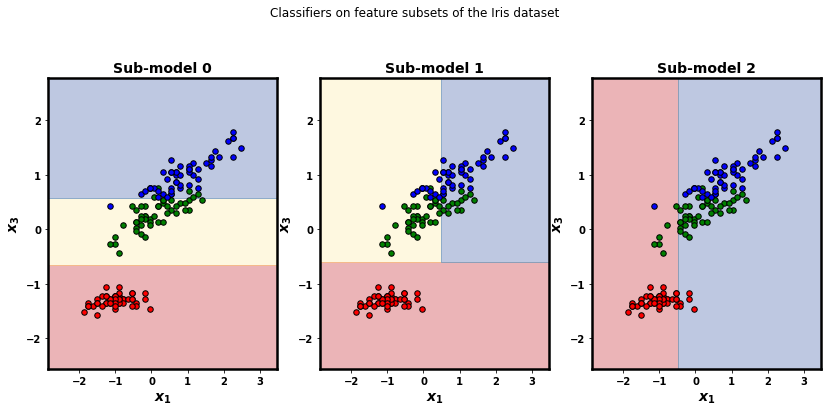

In [8]:
fig_submodels

By superimposing these boundaries on top of one another, we can visualize the "vote"


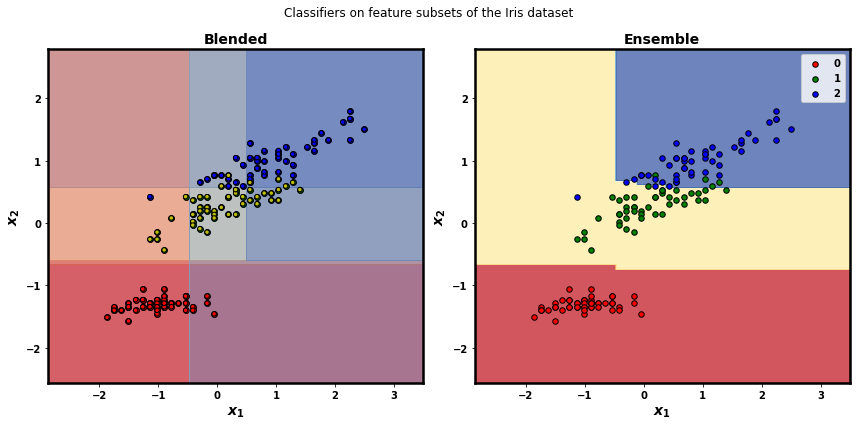

In [9]:
fig_sum

- The left plot is the super-position
- The right plot is the final boundary of the ensemble

You can see that the combination of the weak learners does a pretty good job !

# Bagging, Bootstrapping

One way to construct multiple weak learners of the *same* type of model
- Is to train each individual model on a *restricted* set of training examples

Because each individual model is trained on different examples, the predictions made by
each are hopefully somewhat independent.

Given the full set of training examples
$$ \langle \X, \y \rangle = [ \x^\ip, \y^\ip | 1 \le i \le m ]$$

we construct a restricted set of examples 
$$ \langle \X_\tp, \y_\tp \rangle $$
on which to train the $\tt^{th}$ individual model

The restricted set 
is constructed by
- Selecting $m$ examples at random from $\langle \X, \y \rangle$
- *With replacement*
- So it is possible for an example $i'$ to appear more than once in $ \langle \X_\tp, \y_\tp \rangle$

This process is called *bootstrapping* (or *bagging*) and results in
- $ \langle \X_\tp, \y_\tp \rangle = [ \x^{(i')}, \y^{(i')} | i' \in \{ i_1, \ldots, i_m \} ] $
- Where $i_1, \ldots, i_m$ are the indices of the $m$ chosen examples

<br>
<table>
    <tr>
        <center><strong>Bagging</strong></center>
    </tr>
    <br><br>
<img src=images/Bagging.png>
</table>

If each of the $m$ examples in $ \langle \X, \y \rangle$ is chosen with equal probability $\frac{1}{m}$
- The probability of a particular example $i$ **not** being in $ \langle \X_\tp, \y_\tp \rangle$ is
$$
( 1 - \frac{1}{m} )^m
$$

Let's plot this probability as a function of the training dataset size $m$

In [10]:
m = np.arange(50, 1000, 50)
p = (1 - 1/m)**m


fig, ax = plt.subplots(1,1, figsize=(12,6))
_= ax.plot(m, p)
_= ax.set_xlabel("m")
_= ax.set_ylabel("prob not in bootstrapped sample")
_= ax.set_yticklabels( [ "{:.2%}".format(y) for y in p])
plt.close(fig)

/home/kjp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


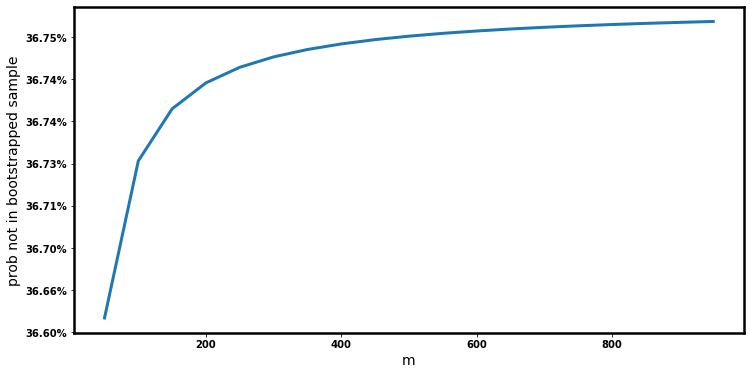

In [11]:
fig

Thus about 63% of the examples in the bootstrapped set are duplicates.

Why is this a potential advantage ?
- the model may perform better (in-sample) on duplicated examples
- the model can't overfit  to any example that is not in its training set.

The process of
- Bootstrapping restricted training examples
- Training individual models on the bootstrapped examples
- Aggregating model predictions into a single prediction

is called *bagging* and each individual training set is called a bag

Bagging has a nice side-effect
- About 37% of the full set of examples are not present in a given bag
- Called *out of bag*

The out of bag examples thus can be used to test out of sample prediction !
- a built-in validation dataset

# Random Forests

A Random Forest
- Is a collection of Decision Trees
- Of restricted power (weak learners)
- Created by Bagging


The learners are made weak by
- Training on a bootstrapped subset
- By limiting the depth of the Decision Tree
- By limiting the choice of feature on which to split a node
    - To a random subset of all features
    
The result is that the individual models (Decision Trees) are relatively independent.

# Boosting

There is another approach to creating ensembles of weak learners.

The method is called *boosting*
- Rather than create weak learners independently, i.e., a *set*
- Boosting creates a *sequence* of weak learners: $M_{(0)}, M_{(1)}, \ldots, M_{(M)}$
- Where the $(\tt +1)^{th}$ individual model in the sequence
- Focuses on correctly predicting those examples *incorrectly* predicted by the $\tt^{th}$ individual model

**Notation**

We will be dealing with many sequences.  We use subscripts in parentheses to index elements of a sequence.
$$M_{(0)}, M_{(1)}, \ldots, M_{(M)}$$

Recall:
- when bootstrapping/bagging
- each individual training dataset is drawn simultaneously from the full training dataset

<br>
<table>
    <tr>
        <center><strong>Bagging</strong></center>
    </tr>
    <br><br>
<img src=images/Bagging.png>
</table>

In contrast
- *boosting* creates the individual training datasets **sequentially**
- subset $\langle \X_{(\tt+1)}, \y_{(\tt+1)} \rangle$ for model $M_{(\tt+1)}$
- is chosen to compensate for the errors of **all prior** models $\{ M_{(\tt')} \; | \; \tt' \lt \tt \}$

<br>
<table>
    <tr>
        <center><strong>Boosting</strong></center>
    </tr>
    <br><br><br><br>
<img src=images/Boosting.png>
</table>

How do we get an individual model to focus on some particular examples ?
- By assigning each example a weight
- Increasing the probability that more heavily weighted examples are included in the training examples for the model
    - examples with poor predictions by earlier models are over-weighted in the subsequent model

Let $\text{say}_\tp^\ip$ denote the weight assigned to example $i$ in the training set for the $\tt^{th}$
individual model

The "say" is adjusted from the $\tt^{th}$ model to the $(\tt+1)^{th}$ individual model

$
\begin{array}[lll]\\
\text{If example } i \text{ is incorrectly predicted in model } \tt: & \text{say}_{(\tt+1)}^\ip > \text{say}_\tp^\ip \\
\text{If example } i \text{ is correctly predicted in model } \tt: & \text{say}_{(\tt+1)}^\ip <\text{say}_\tp^\ip \\
\end{array}
$


When bootstrapping, rather than drawing examples with equal probability
- Draw examples for model $(\tt +1)$ in proportion to it's $\text{say}_{(\tt+1)}^\ip$
- So examples that were "problematic" in model $\tt$ are over-represented in training model $(\tt+1)$

- Boosting creates a collection of "specialists" (focus on hard to predict examples)
- Bagging creates a collection of "generalists", each a little better than random

## AdaBoost

AdaBoost is a particular model that uses boosting
- The individual models are Decision Trees
    - Usually depth $1$; "stumps"
- There is an "importance" associated with each individual model 
- Models with higher weight have a greater impact on ensemble prediction


Let
$$\text{importance}_\tp$$ 
denote the weight of the $\tt^{th}$ individual model in the sequence.

- $\text{importance}_\tp$ is determined by the Performance Metric (e.g., Accuracy) of individual model $\tt$

- The class predicted by the ensemble is the one with highest *importance-weighted* average  (across individual models) probability
$$
\hat{\y}^\ip = \argmax{c}{ \sum_{\tt=1}^M} { ( p_{\tp,c}^\ip * \text{importance}_\tp)}
$$

Thus, models that are more successful have greater weight.

## Example: Boosting for a Regression task

Boosting is often associate with Classification tasks
- for example: the individual models are Decision Trees

Here we show how it may be used for Regression.

Our goal is to solve for the optimal parameters $\Theta^*$ for the Linear Regression
$$
\y = \Theta \cdot \x + \epsilon
$$

That is, $\Theta^*$ minimizes the MSE
$$
\Theta^* = \argmin{\Theta}{\frac{1}{m} \sum_i { (\y^\ip - \Theta \cdot \x^\ip)^2)} }
$$



The Boosting method
- creates a sequence of approximations of the optimal parameters $\Theta$
$$
\Theta^*_{(0)}, \Theta^*_{(1)}, \ldots
$$
that approach the optimal $\Theta^*$.



Boosting creates a sequence of models
$$M_{(0)}, M_{(1)}, \ldots, M_{(M)}$$

such that model $M_{(\tt+1)}$ compensates for the errors of earlier models $M_{(\tt')}$ in the sequence.

Each model $M_\tp$ in the sequence has a functional form that is a Linear

Model $\tt$
$$
\begin{array} \\
\e_\tp & = & \Theta_\tp \cdot \x  & + & \epsilon_\tp \\
& = & \hat \e_\tp & + & \epsilon_\tp & \text{define } \hat \e_\tp = \Theta_\tp \cdot \x\\
\end{array}
$$

where
- $\Theta_\tp $ are the parameters of the model $M_\tp$
- $\e_\tp$ is the target (to be defined)
- $\hat \e_\tp$ is the predicted value
- $\epsilon_\tp$ is the prediction error


For the first model Model $M_{(0)}$
- target is $\y$
$$
\e_{(0)} = \y
$$
- we ignore the features $\x$ and predict the average
$$
\hat \e_{(0)} = \bar \y
$$
- the intercept parameters is $\bar \y$, all other parameters are $0$
$$
\Theta_{(0)} = (\bar \y, 0, \ldots, 0)
$$

For subsequent models $\tt + 1$
- the target $\e_{(\tt+1)}$
- is the *error* of the previous model $M_\tp$
$$
\e_{(\tt+1)} = \epsilon_\tp
$$

Model $M_{(\tt+1)}$ tries to find
- additional explanatory power in the $\x$
- by creating $\hat\e_{(\tt+1)} = \Theta_{(\tt+1)} \cdot \x$
- that reduces the previous error $\epsilon_\tp$

If no additional explanatory power is possible, i.e., $\epsilon_\tp$ (the new target) 
- is $0$
- or uncorrelated with $\x$

then the sequence of models is not extended further.

Here is a picture of the sequence of models along with their 
- targets $\e_\tp$
- predictions $\hat \e_\tp$
- and errors $\epsilon_\tp$

$$
\begin{array} \\
\text{#} & \e_\tp & \hat \e_\tp & \epsilon_\tp \\
\hline \\
0 & \y & \Theta_{(0)} \cdot \x & \epsilon_{(0)} \\
1 & \epsilon_{(0)}  & \Theta_{(1)} \cdot \x & \epsilon_{(1)} \\
\vdots \\
M & \epsilon_{(M-1)}  & \Theta_{(M)} \cdot \x & \epsilon_{(M)} \\
\end{array}
$$


The prediction $\hat\y_\tp$ of the ensemble of the first $\tt$ models
- is a weighted sum of the predictions of the targets of these models

$$
\begin{array} \\
\hat{\y}_\tp & = & \sum_{\tt'=0}^\tt { \alpha_\tp * \hat{\e}_\tp } \\
& = & \x \cdot \sum_{\tt'=0}^\tt { \alpha_\tp *  \Theta_{(\tt')} } \\
\end{array}
$$

The boosting solution thus derives
the coefficients $\Theta^*$ of a direct Linear Regression model
$$
\hat \y = \Theta^* \cdot \x
$$
iteratively, as a sum
$$
\Theta^* = \sum_{\tt'=0}^\tt { \alpha_\tp *  \Theta_{(\tt')} } 
$$

The parameter $\Theta_\tp$ at step $\tt$
- is an *update* of estimate $\Theta^*_{(\tt-1)}$

We will demonstrate a method
- called *Gradient Descent*
- that will define the sequence of parameter *updates* $\Theta_{(1)}, \ldots, \Theta_{(M)}$

in a subsequent module.

We call the new sequence of $\Theta$'s "updates" 
- since $\Theta_\tp$  
- updates the estimate of $\Theta^*$ from the shorter sequence of $(\tt-1)$ models.

Since these boosting process uses Gradients, it is 
called *Gradient Boosting*.

**Note**

If we had used Linear Regression to obtain the updates $\Theta_\tp$ for model $M_\tp$
- then $\epsilon_\tp$ is *uncorrelated* with $\x$
    - property of Ordinary Least Squares (OLS) Regression
- the sequence of models is not extended

We now relate the final prediction $\hat\y_{(M)}$
- to the true target $\y$.

Since the prediction $\hat \e_\tp$ of model $M_\tp$ is the difference between target and error
$$
\hat \e_\tp = \e_\tp - \epsilon_\tp
$$
we can write  the ensemble prediction (sum across the predictions of all models) as
$$
\begin{array} \\
\hat\y_{(M)} & = & \sum_{\tt'=0}^M { (\e_{(\tt')} - \epsilon_{(\tt')}) } & \text{ letting } \alpha_\tp = 1 \text{ for all } \tt \\
& = & (\e_{(0)} - \epsilon_{(0)}) + \sum_{\tt'=1}^M { (\e_{(\tt')} - \epsilon_{(\tt')})  } & \text{moving } \tt'=0 \text{ out of the sum }\\
& = & (\e_{(0)} - \epsilon_{(0)}) +\sum_{\tt'=1}^M { (\epsilon_{(\tt'-1)} - \epsilon_{(\tt')}) } & \text{since } \e_{(\tt')} =  \epsilon_{(\tt'-1)} \\
& & & \text{the target of model } \tt' \text{ is the error of model } \tt'-1 \\
& = & \e_{(0)} - \epsilon_{(M)} & \text{the negative } - \epsilon_{(\tt)}  \text{ term  occurring when } \tt' = \tt  \\
& & & \text{is canceled by the positive } \epsilon_{(\tt'-1)} \text{ term occurring when } \tt' = \tt +1 \\
 & & & \text{e.g., } - \epsilon_{(0)} \text{ (outside the sum) is canceled by } \epsilon_{(\tt'-1)} \text{ term when } \tt' = 1 \\
 & & & \text{ and } - \epsilon_{(\tt)} \text{ term occurring when } \tt'=\tt \text{ is cancelled by } \epsilon_{(\tt'-1)} \text{ when } \tt'=\tt+1 \\
 & = & \y -  \epsilon_{(M)} & \text{since } \e_{(0)} = \y \\
 \end{array}
$$

That is, $\hat\y_{(M)}$
- is an approximation of true target $\y$
- with error $\epsilon_{(M)}$

Re-arranging terms we get the familiar linear form for Linear Regression
$$
 \y  =  \hat\y_{(M)} + \epsilon_{(M)}$$

## Example: Boosting for a Classification task

Although we won't construct an example for Classification, there are some important
points to consider.

Each model is created from *scratch*
- Model $M_{(\tt+1)}$ does **not** extend model $M_\tp$
- For example, if the models are Decision Trees
    - the tree for $M_{(\tt+1)}$ is not an expansion of the tree for $M_\tp$

Although the models are created *independently*
- their *training datasets* are constructed sequentially



In [12]:
print("Done")

Done
